## 각종 필요 패키지 import

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

## CSV 파일 line 수를 저장하는 클래스 정의

In [2]:
class DLQC():
    def __init__(self, years):
        self.years = years
        for year in years:
            setattr(self, f'min_{year}', defaultdict(lambda: np.zeros(shape=12)))
            setattr(self, f'qcd_{year}', defaultdict(lambda: np.zeros(shape=12)))

# dlqc.min_2021[stn_id][0:12] = lines

## csv line 세는 함수 정의

In [3]:
def get_lines_with_csv_path(path):
    chunk = 1024*1024   # Process 1 MB at a time.
    f = np.memmap(path, mode='r')
    num_newlines = sum(np.sum(f[i:i+chunk] == ord('\n')) for i in range(0, len(f), chunk))
    del f
    return num_newlines

## 간단한 비교

먼저 모든 csv 파일을 다 읽진 않고 줄바꿈 수만 읽어서 line 수만 저장해놓는다.

In [4]:
data_dir = 'CSV3DB'
header_name = ['time', 'ta', 'wd', 'ws', 'rn', 'pa', 're', 'sd', 'hm']
dtype_dict = {
    'ta': np.float32,
    'wd': np.float32,
    'ws': np.float32,
    'rn': np.float32,
    'pa': np.float32,
    're': np.float32,
    'sd': np.float32,
    'hm': np.float32
    }
years = list(map(int, filter(lambda x: not x.endswith('pickle'), os.listdir(data_dir)))) # [2021, 2022]

dlqc = DLQC(years)

for year in years:
    year = str(year)
    pbar = tqdm(os.listdir(os.path.join('CSV3DB', year)), desc=year)
    for csv_name in pbar:
        if csv_name.endswith('csv'):
            _, _, m_q, stn_id, date = csv_name.split('_')
            stn_id = int(stn_id)
            date, _ = date.split('.')
            date = int(date)
            getattr(dlqc, f'{m_q}_{year}')[stn_id][date % 100 - 1] = get_lines_with_csv_path(os.path.join('CSV3DB', year, csv_name))


2022: 100%|██████████| 16330/16330 [00:46<00:00, 353.34it/s]


In [5]:
# station id가 몇 개인지 확인
len(dlqc.min_2021), len(dlqc.qcd_2021), len(dlqc.min_2022), len(dlqc.qcd_2022)

(761, 761, 754, 753)

2021년과 2022년의 stn_id 개수가 서로 맞지 않는다.

또, 2022년의 min과 qcd의 stn_id 개수가 같지 않다.

먼저 2021년 min, qcd간의 stn_id와 2022년 min, qcd간의 stn_id가 서로 같은지 확인한다.

In [6]:
# 2021년은 같지만 2022년은 다르다.
set(dlqc.min_2021) == set(dlqc.qcd_2021), set(dlqc.min_2022) == set(dlqc.qcd_2022)

(True, False)

In [7]:
set(dlqc.min_2022) - set(dlqc.qcd_2022), set(dlqc.qcd_2022) - set(dlqc.min_2022)

({111}, set())

2022년 111번은 min은 있지만 qcd가 없다.

2022년 111번 min csv 이름 찾기

In [8]:
no_qcd_list = list(filter(lambda x: x.startswith('dlqc_aws3_min_111'), os.listdir(os.path.join(data_dir, '2022'))))
no_qcd_list

['dlqc_aws3_min_111_202207.csv']

In [9]:
# 하나의 csv파일이므로 열어서 확인
bad_df = pd.read_csv(os.path.join(data_dir, '2022', no_qcd_list[0]),
                      names=header_name)
bad_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,56.000000,56.000000,56.000000,56.0,56.0,56.0,56.0,56.000000
mean,30.235714,185.366071,1.091071,0.0,-999.0,-999.0,-999.0,-661.232143
std,1.508452,144.805072,0.524760,0.0,0.0,0.0,0.0,495.211286
min,26.600000,0.000000,0.100000,0.0,-999.0,-999.0,-999.0,-999.000000
25%,29.650000,39.550000,0.700000,0.0,-999.0,-999.0,-999.0,-999.000000
50%,30.500000,190.050000,1.100000,0.0,-999.0,-999.0,-999.0,-999.000000
75%,31.500000,326.125000,1.300000,0.0,-999.0,-999.0,-999.0,48.000000
max,32.800000,359.800000,2.400000,0.0,-999.0,-999.0,-999.0,58.000000


In [10]:
bad_df.head(10)

,time,ta,wd,ws,rn,pa,re,sd,hm
0,2022.07.11 15:53:00,28.3,315.9,2.0,0.0,-999.0,-999,-999.0,-999
1,2022.07.11 15:54:00,28.3,285.4,2.1,0.0,-999.0,-999,-999.0,-999
2,2022.07.11 15:55:00,28.2,209.4,1.3,0.0,-999.0,-999,-999.0,-999
3,2022.07.11 15:57:00,28.2,348.5,1.0,0.0,-999.0,-999,-999.0,-999
4,2022.07.11 16:10:00,27.9,317.7,1.5,0.0,-999.0,-999,-999.0,-999
5,2022.07.11 16:11:00,27.9,335.1,2.4,0.0,-999.0,-999,-999.0,-999
6,2022.07.11 16:12:00,27.9,318.5,2.2,0.0,-999.0,-999,-999.0,-999
7,2022.07.11 16:13:00,27.9,311.5,1.9,0.0,-999.0,-999,-999.0,-999
8,2022.07.11 16:14:00,27.9,329.5,2.2,0.0,-999.0,-999,-999.0,-999
9,2022.07.11 16:15:00,27.9,315.2,1.5,0.0,-999.0,-999,-999.0,-999


In [11]:
# 너무 적은 timestep을 갖고 있어 버려도 될 것으로 판단, 초기화한다.
del(dlqc.min_2022[111])

In [12]:
set(dlqc.min_2021) == set(dlqc.qcd_2021), set(dlqc.min_2022) == set(dlqc.qcd_2022)

(True, True)

지금까지 2021년 내, 2022년 내에서 비교했다면, 이젠 2021년과 2022년 간의 stn_id를 비교한다.

In [13]:
print('2021년에만 있는 stn_id', set(dlqc.min_2021) - set(dlqc.min_2022))
print('2022년에만 있는 stn_id', set(dlqc.min_2022) - set(dlqc.min_2021))

2021년에만 있는 stn_id {0, 484, 197, 684, 111, 880, 562, 981, 89, 220, 894, 895}
2022년에만 있는 stn_id {994, 34, 347, 348}


해당 년월에 min과 qcd csv파일이 서로 있는지, line수는 같은지 확인

In [14]:
both_count = both_count_line_diff = min_count = qcd_count = 0
for year in years:
    year = str(year)
    pbar = tqdm(getattr(dlqc, f'min_{year}'), desc=year)
    for stn_id in pbar:
        min_list = getattr(dlqc, f'min_{year}')[stn_id]
        qcd_list = getattr(dlqc, f'qcd_{year}')[stn_id]
        for month_idx in np.where((min_list > 0) | (qcd_list > 0))[0]:
            # min, qcd 둘 다 있는 월
            if month_idx in np.where((min_list > 0) & (qcd_list > 0))[0]:
                if min_list[month_idx] == qcd_list[month_idx]:
                    both_count += 1
                elif min_list[month_idx] != qcd_list[month_idx]:
                    both_count_line_diff += 1
                
            # min만 있는 월. 예측엔 도움이 될것이지만 이상치 탐지에 사용하기는 어려울듯
            elif month_idx in np.where((min_list > 0))[0]:
                min_count += 1
            # qcd만 있는 월. 쓸 수 없다
            else:
                qcd_count += 1

# 라인수가 같은 것 / 라인수가 다른 것 / min만 있는 것 / qcd만 있는것
both_count, both_count_line_diff, min_count, qcd_count

2022: 100%|██████████| 753/753 [00:00<00:00, 8702.36it/s]


(13510, 2739, 1513, 0)

결국 모든 csv파일을 pandas로 읽어 다음과 같은 내용을 확인해 시각화해보려한다.

1. stn별 어떤 기상 요소를 관측하는지,

2. column별 결측치 비율

관측소별 기상 요소의 측정 유무의 판단은 1분이라도 측정한 값과 함께 qcd가 정상인 경우가 있다면 측정한다고 판단한다.

## 시각화

모든 csv파일을 dataframe화해서 메모리에 올려놓고 싶지만, 메모리 용량 한계로 그럴 수 없었다.

따라서 하나씩 csv파일을 읽고 중간에 빠진 시간대를 nan으로 채워 넣은뒤

원하는 결과를 중간에 저장하는 방식으로 진행한뒤 시각화를 진행한다.


In [15]:
# year, month, stn_id를 가지고 min_df와 qcd_df를 return하는 함수 정의
# full_date를 가지며 -999결측치는 nan으로 바꾼다.
def get_min_qcd_df_with_fulldate_nan(year, month, stn_id):
    full_date = pd.Series(pd.date_range(datetime(year, month, 1), datetime(year, month, 1) + relativedelta(months=1), freq='T', inclusive='left'), name='time')
    # min csv 읽고, 비어있는 time step nan으로 채워넣기
    min_df = pd.read_csv(os.path.join(data_dir, str(year), f'dlqc_aws3_min_{stn_id:03d}_{year}{month:02d}.csv'),
                        header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], dtype=dtype_dict)
    min_df = pd.merge(min_df, full_date, how='outer')
    min_df.set_index('time', inplace=True)
    min_df.sort_index(inplace=True)
    
    # qcd csv가 있으면 읽고, 없으면 nan으로 초기화
    if os.path.isfile(os.path.join(data_dir, str(year), f'dlqc_aws3_qcd_{stn_id:03d}_{year}{month:02d}.csv')):
        qcd_df = pd.read_csv(os.path.join(data_dir, str(year), f'dlqc_aws3_qcd_{stn_id:03d}_{year}{month:02d}.csv'),
                                header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], dtype=dtype_dict)
        qcd_df = pd.merge(qcd_df, full_date, how='outer')
        qcd_df.set_index('time', inplace=True)
        qcd_df.sort_index(inplace=True)
    else:
        qcd_df = min_df.copy()
        qcd_df[:] = np.nan

    # -999같이 -900보다 작은 값은 결측값으로 판단, nan처리
    # 같은 시간대의 qcd에도 1로 지정한다.
    qcd_df[min_df < -900] = 1
    min_df[min_df < -900] = np.nan

    return min_df, qcd_df
    

In [16]:
# 결과를 저장할 dictionay
# stn_id를 key로 갖는다.
stn_to_usecol = dict()

stn_to_notnull = dict()
stn_to_null = dict()

stn_to_qcd0 = dict()
stn_to_qcdnan = dict()
stn_to_qcd1 = dict()


# 결과물을 pickle로 저장, 불러오며 사용
if os.path.isfile(os.path.join(data_dir, 'visual.pickle')):
    with open(os.path.join(data_dir, 'visual.pickle'), 'rb') as f:
        stn_to_usecol, stn_to_notnull, stn_to_null, stn_to_qcd0, stn_to_qcdnan, stn_to_qcd1 = pickle.load(f)
else:
    # stn_id에 대해 해당하는 모든 csv파일을 읽는다.
    for stn_id in tqdm(set(dlqc.min_2021) | set(dlqc.min_2022)):
        # 6가지의 결과물 담을 임시 배열
        result_list = [list() for _ in range(6)]

        for year in years:
            if stn_id in set(getattr(dlqc, f'min_{year}')):
                for month_idx in np.where(getattr(dlqc, f'min_{year}')[stn_id] > 0)[0]:
                    min_df, qcd_df = get_min_qcd_df_with_fulldate_nan(year, month_idx+1, stn_id)

                    result_list[0].append(((min_df.notnull()) & (qcd_df == 0)).any())
                    
                    result_list[1].append(min_df.notnull().sum())
                    result_list[2].append(min_df.isnull().sum())

                    result_list[3].append((qcd_df == 0).sum())
                    result_list[4].append((qcd_df.isnull().sum()))
                    result_list[5].append((qcd_df == 1).sum())

        stn_to_usecol[stn_id] = dict(pd.concat(result_list[0], axis=1).any(axis=1))

        stn_to_notnull[stn_id] = dict(pd.concat(result_list[1], axis=1).sum(axis=1))
        stn_to_null[stn_id] = dict(pd.concat(result_list[2], axis=1).sum(axis=1))

        stn_to_qcd0[stn_id] = dict(pd.concat(result_list[3], axis=1).sum(axis=1))
        stn_to_qcdnan[stn_id] = dict(pd.concat(result_list[4], axis=1).sum(axis=1))
        stn_to_qcd1[stn_id] = dict(pd.concat(result_list[5], axis=1).sum(axis=1))


    # pickle로 저장
    with open(os.path.join(data_dir, 'visual.pickle'), 'wb') as f:
        pickle.dump([stn_to_usecol, stn_to_notnull, stn_to_null, stn_to_qcd0, stn_to_qcdnan, stn_to_qcd1], f, protocol=pickle.HIGHEST_PROTOCOL)


stn별로 어떤 기상요소들을 수집하는지 시각화

[Text(0, 0, '549'),
 Text(0, 0, '560'),
 Text(0, 0, '727'),
 Text(0, 0, '744'),
 Text(0, 0, '752'),
 Text(0, 0, '757'),
 Text(0, 0, '760'),
 Text(0, 0, '760')]

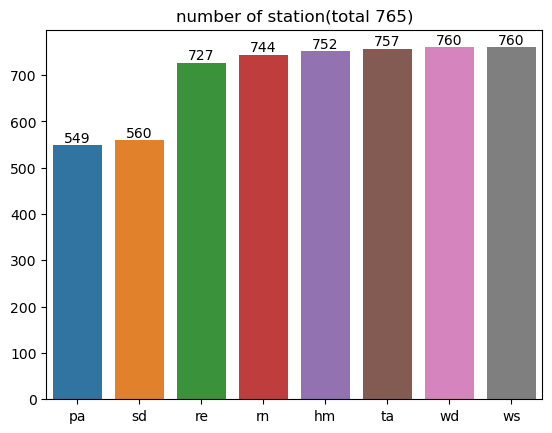

In [17]:
data_col = pd.DataFrame(stn_to_usecol).sum(axis=1).sort_values()
bar = sns.barplot(x=data_col.index, y=data_col)
bar.set_title(f'number of station(total {len(stn_to_usecol)})')
bar.bar_label(bar.containers[0])

In [18]:
# TODO
col_to_stn_sum = defaultdict(list)
for k, v in stn_to_usecol.items():
    col_to_stn_sum[tuple(col for col, b in v.items() if b)].append(k)

total_col_to_stn_sum = [(cols, len(stns)) for cols, stns in col_to_stn_sum.items()]
total_col_to_stn_sum.sort(key=lambda x: -x[1])
total_col_to_stn_sum

[(('ta', 'wd', 'ws', 'rn', 'pa', 're', 'sd', 'hm'), 477),
 (('ta', 'wd', 'ws', 'rn', 're', 'hm'), 119),
 (('ta', 'wd', 'ws', 'rn', 're', 'sd', 'hm'), 75),
 (('ta', 'wd', 'ws', 'rn', 'pa', 're', 'hm'), 46),
 (('ta', 'wd', 'ws', 'rn', 'pa', 'hm'), 17),
 (('ta', 'wd', 'ws', 'pa', 'hm'), 8),
 (('ta', 'wd', 'ws', 'hm'), 7),
 (('ta', 'wd', 'ws', 'rn', 're'), 5),
 (('sd',), 5),
 (('wd', 'ws', 'rn', 're', 'sd'), 2),
 (('wd', 'ws', 'rn', 're', 'hm'), 1),
 (('ta', 'wd', 'ws', 'rn', 'hm'), 1),
 (('ta', 'wd', 'ws', 'rn', 're', 'sd'), 1),
 (('ta', 'wd', 'ws', 'pa', 're', 'hm'), 1)]

In [19]:
val_pc_df = pd.DataFrame([], columns=header_name[1:])
for (k, nnv), (_, nv) in zip(stn_to_notnull.items(), stn_to_null.items()):
    val_pc_df.loc[k] = [v1 / (v1 + v2) * 100 for v1, v2 in zip(nnv.values(), nv.values())]
val_pc_df

,ta,wd,ws,rn,pa,re,sd,hm
0,39.324074,39.324074,39.324074,0.000000,0.000000,0.000000,0.000000,39.324074
1,0.963828,0.987866,0.987866,0.983288,0.043117,0.987866,0.000000,0.788309
10,98.633467,98.634513,98.634228,98.639079,93.710046,98.639555,29.142409,98.612919
12,98.860731,98.860731,98.860731,98.860731,98.860635,98.860731,98.860731,98.860731
13,87.109280,87.109280,87.109280,87.109280,87.109280,87.109280,0.001399,87.109280
...,...,...,...,...,...,...,...,...
989,96.366917,96.366917,96.366917,96.366917,96.366917,96.366917,96.366917,96.366917
990,96.250978,96.250978,96.250978,96.048513,96.250978,96.250978,18.821890,96.250978
991,97.954649,97.954649,97.954649,97.954649,97.954649,97.954649,23.552100,97.954649
992,97.956931,97.956931,97.956931,97.956931,96.252771,97.956931,23.550796,97.956931


In [20]:
val_pc_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,95.753854,95.808684,95.811581,93.993856,68.322043,92.991213,51.665442,93.448094
std,15.880520,15.710169,15.711515,20.512272,43.019615,23.570005,39.848247,19.963471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98.936263,98.937976,98.939106,98.905441,11.042333,98.905441,0.000000,98.630137
50%,99.783676,99.789954,99.797184,99.792237,99.277492,99.794521,59.637272,99.759608
75%,99.894882,99.895643,99.897355,99.896404,99.876903,99.896404,97.830670,99.893740
max,99.956906,99.956906,99.956906,99.956906,99.950818,99.956906,99.956906,99.956906


<Axes: >

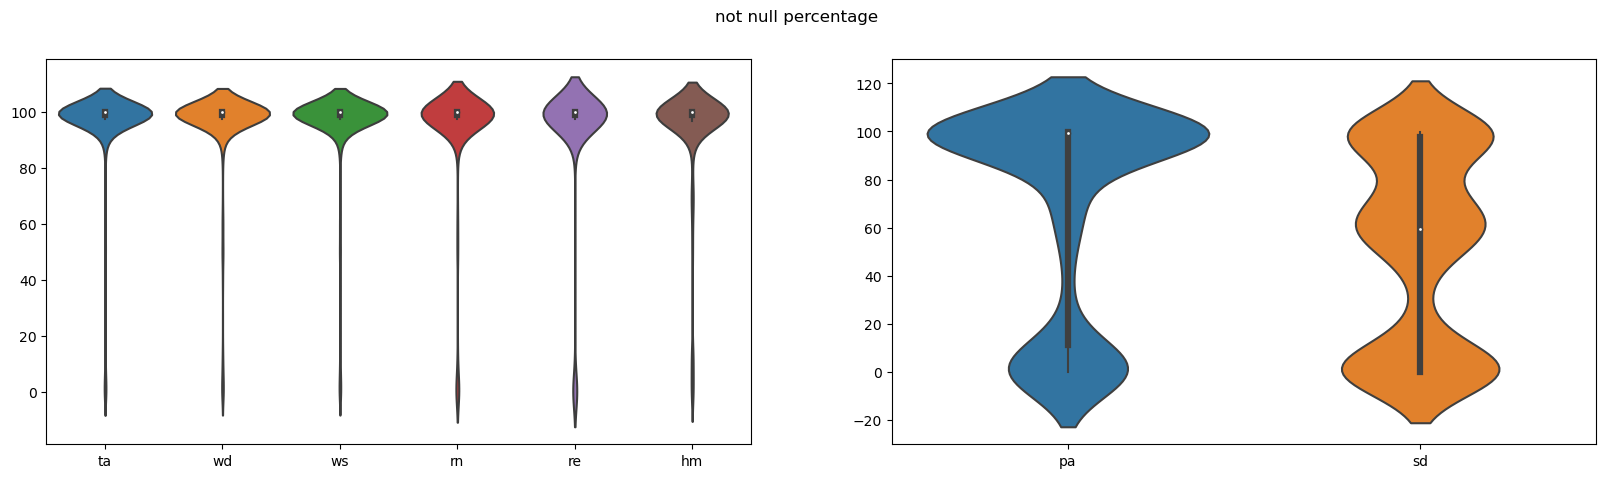

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('not null percentage')
sns.violinplot(val_pc_df[['ta', 'wd', 'ws', 'rn', 're', 'hm']], ax=axes[0])
sns.violinplot(val_pc_df[['pa', 'sd']], ax=axes[1])

In [22]:
qcd_norm_pc_df = pd.DataFrame([], columns=header_name[1:])
qcd_anorm_pc_df = pd.DataFrame([], columns=header_name[1:])

for (k, vq0), (_, vqnan), (_, vq1) in zip(stn_to_qcd0.items(), stn_to_qcdnan.items(), stn_to_qcd1.items()):
    qcd_norm_pc_df.loc[k] = [v0 / (v0 + vnan + v1) * 100 for v0, vnan, v1 in zip(vq0.values(), vqnan.values(), vq1.values())]
    qcd_anorm_pc_df.loc[k] = [v1 / (v0 + vnan + v1) * 100 for v0, vnan, v1 in zip(vq0.values(), vqnan.values(), vq1.values())]

qcd_norm_pc_df

,ta,wd,ws,rn,pa,re,sd,hm
0,39.324074,39.324074,39.324074,0.000000,0.000000,0.000000,0.000000,39.322531
1,0.000000,0.017170,0.019841,0.019460,0.000000,0.014499,0.000000,0.018315
10,98.077816,97.341419,97.341324,91.453672,93.152397,95.869863,28.585712,98.030346
12,78.032154,78.033676,78.033676,77.663242,78.033581,77.660483,78.033676,78.033676
13,85.630469,85.630469,85.631868,85.504426,85.630469,81.309142,0.001399,85.630469
...,...,...,...,...,...,...,...,...
989,70.016393,69.952072,69.928051,69.777209,70.015824,69.894467,70.020492,70.015824
990,95.094549,95.095364,95.095038,93.451682,95.094875,94.896811,18.821564,95.095201
991,96.798872,96.798709,96.798383,95.752967,96.798057,92.860915,23.552100,96.799198
992,96.801154,96.782081,96.777680,96.811750,95.113132,96.704160,23.550796,96.801480


In [23]:
qcd_norm_pc_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,82.959933,82.503497,82.532285,80.536889,49.667340,79.767287,46.456406,77.524138
std,17.092904,17.686260,17.576899,20.143152,43.321215,22.840913,35.616276,22.420892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,77.572013,77.422850,77.360065,76.657344,0.000000,76.744387,0.000000,75.677416
50%,77.899448,77.886225,77.873002,77.648402,70.706145,77.789998,56.037766,77.829909
75%,99.019502,98.804890,98.744768,97.503615,98.583048,98.075533,77.358067,98.558124
max,99.288908,99.292142,99.292142,99.259893,99.292618,99.268550,99.270072,99.292523


In [24]:
qcd_anorm_pc_df

,ta,wd,ws,rn,pa,re,sd,hm
0,0.000000,0.000000,0.000000,39.324074,39.324074,39.324074,39.324074,0.001543
1,0.024420,0.002671,0.000000,0.004960,0.963065,0.005342,0.987866,0.201084
10,0.024068,0.760464,0.760559,6.648212,4.949486,2.232021,69.516267,0.071537
12,0.001522,0.000000,0.000000,0.370434,0.000095,0.373193,0.000000,0.000000
13,0.001399,0.001399,0.000000,0.127442,0.001399,4.322726,87.107881,0.001399
...,...,...,...,...,...,...,...,...
989,0.004098,0.068420,0.092441,0.243283,0.004668,0.126025,0.000000,0.004668
990,0.016791,0.015975,0.016302,1.659657,0.016465,0.214528,77.429414,0.016138
991,0.015812,0.015975,0.016302,1.061718,0.016628,3.953769,74.402550,0.015486
992,0.016138,0.035211,0.039613,0.005543,1.704160,0.113132,74.406136,0.015812


In [25]:
qcd_anorm_pc_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,1.006836,1.460814,1.431702,3.584809,39.818905,4.410611,45.410937,6.770745
std,8.601345,9.718194,9.460967,15.044570,43.617092,16.631463,38.235317,18.974139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003900,0.007801,0.015316,0.306697,0.010369,0.078672,1.707097,0.005232
50%,0.010654,0.051275,0.074962,0.657249,1.369102,0.262842,39.771062,0.015812
75%,0.032059,0.201294,0.270643,1.292237,88.761986,0.825438,89.886606,0.190449
max,99.892409,99.598554,99.596271,99.936834,99.956906,99.936834,99.946157,99.892409


<Axes: >

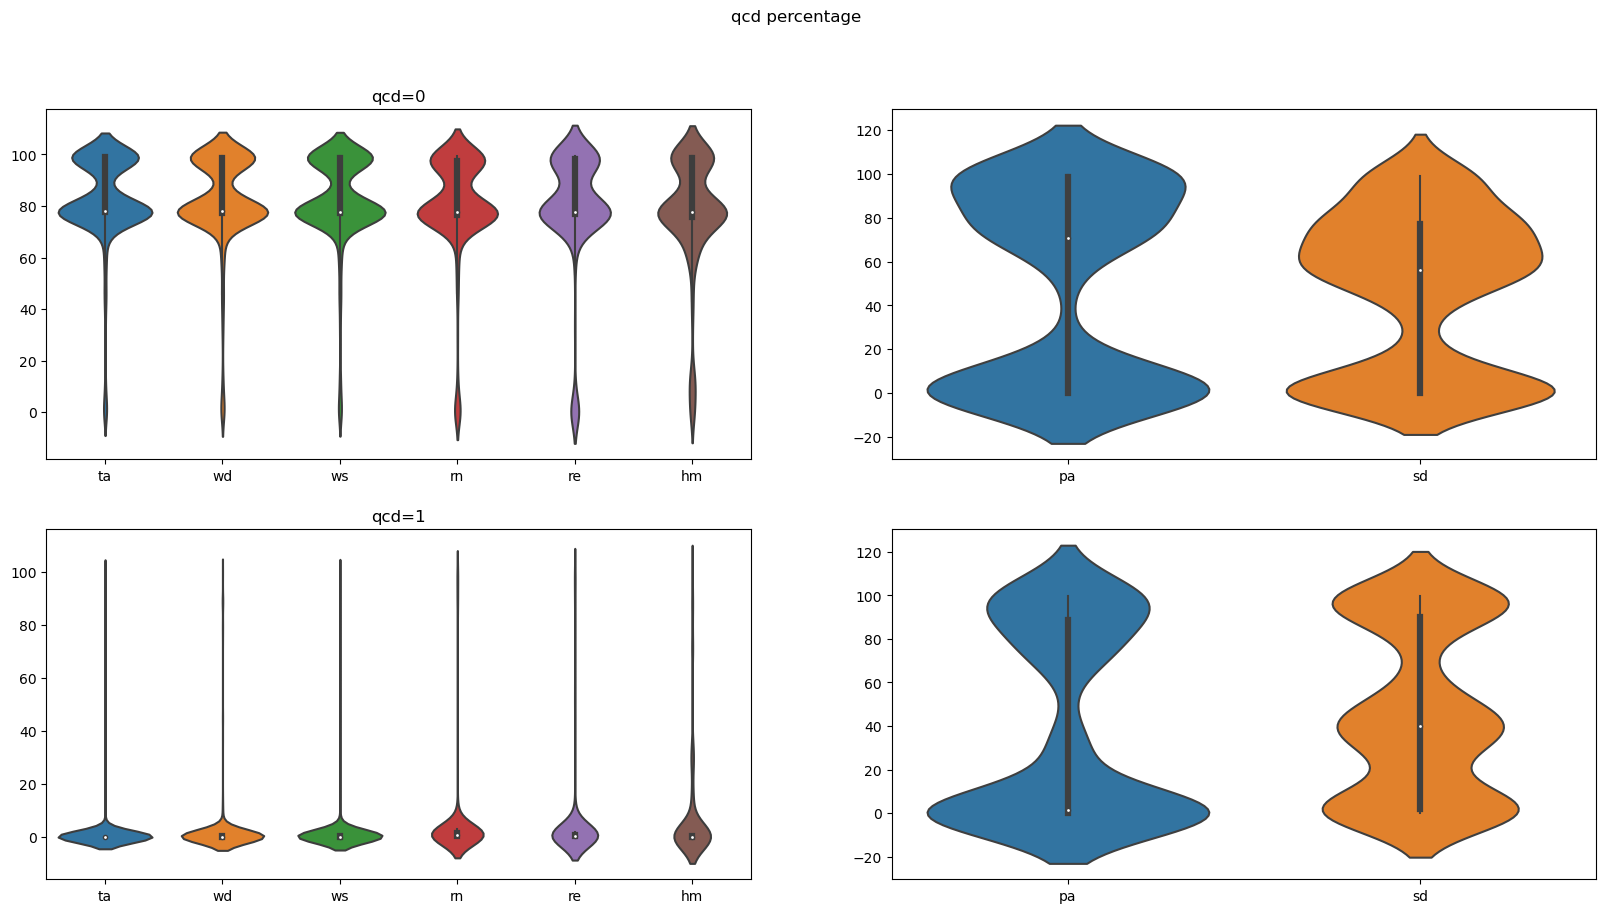

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('qcd percentage')
axes[0][0].set_title('qcd=0')
axes[1][0].set_title('qcd=1')
sns.violinplot(qcd_norm_pc_df[['ta', 'wd', 'ws', 'rn', 're', 'hm']], ax=axes[0][0])
sns.violinplot(qcd_norm_pc_df[['pa', 'sd']], ax=axes[0][1])
sns.violinplot(qcd_anorm_pc_df[['ta', 'wd', 'ws', 'rn', 're', 'hm']], ax=axes[1][0])
sns.violinplot(qcd_anorm_pc_df[['pa', 'sd']], ax=axes[1][1])


## 전처리를 위한 csv 내용을 담는 클래스 정의

여기서 전처리 작업을 진행하는데, 전처리 전략은 다음과 같다.

1. -999와 같은 값은 결측값이라고 판단

2. 기상 요소 중 터무니 없는 값들로만 이루어진 column(pa가 전부 500이나 0, 또는 hm이 전부 0 등)은 qcd와 관계없이 측정하지 않는 기상요소라고 판단, 사용하지 않을 것이다.

3. 각 column당 nan의 비율이 90% 이상이거나 qcd 90% 이상이 1이라면 해당 column은 측정하지 않는 기상요소라고 판단, 사용하지 않을 것이다.

4. wd, ws는 모델이 예측하기 어려운 형태이므로 벡터로 변환, wd_x, wd_y로 변환하여 사용한다.

5. wd_x, wd_y는 둘 중 하나라도 측정하지 않는 기상요소라면 둘 다 사용하지 않는다.

6. 기상요소 예측 모델은 예측을 잘 해야 하므로 정상값들로만 학습시켜야한다. 즉, 결측치, 이상치를 허용해선 안된다.

    따라서 intp_df라는 DataFrame은 결측치, 이상치를 모두 nan으로 처리한뒤 re를 제외한 나머지 기상요소들은 linear interpolation을 이용해 그럴듯한 값으로 채워넣는다.

    re 기상요소는 0과 10만 갖는 값이므로 nearest interpolation을 이용한다.




In [27]:
# 해당 연도의 csv파일을 읽어 dataframe으로 저장
class all_dfs():
    def __init__(self, dlqc: DLQC, year):
        self.min_dfs = dict()
        self.qcd_dfs = dict()

        pbar = tqdm(getattr(dlqc, f'min_{year}'), desc=str(year))
        for stn_id in pbar:
            min_list = getattr(dlqc, f'min_{year}')[stn_id] > 0

            for month_idx in np.where(min_list)[0]:
                min_df, qcd_df = get_min_qcd_df_with_fulldate_nan(year, month_idx+1, stn_id)

                #############
                # 전처리 전략
                #############
                # 1. min의 -900보다 작은 값은 결측값으로 판단, nan처리
                # 같은 시간대의 qcd에도 1로 지정한다.
                qcd_df[min_df < self.qcd_th] = 1
                min_df[min_df < self.qcd_th] = np.nan
                
                # 2. pa가 -999는 아니지만 500근처이거나 0인 것이 많이 관측됨. 이상치라 보지 않고 결측값으로 판단
                # 따라서 pa가 500이하인 것은 nan 처리, qcd는 1로 지정한다.
                # qcd_df.loc[min_df['pa'] <= 500, 'pa'] = 1
                # min_df.loc[min_df['pa'] <= 500, 'pa'] = np.nan
                # hm도 마찬가지


                # 3.각 column당 nan이 90% 이상이거나 qcd가 1인 비율이 90%이상이라면 
                # 해당 column을 측정하지 않는것으로 판단, 모든 값을 결측값 처리해 nan으로한다.
                # 그리고 그 column의 모든 qcd를 1로한다.
                



                # 4. wd, ws를 wd_x, wd_y로 변환하여 사용
                # qcd는 1, nan, 0 순으로 적용되며 
                # wd, ws중 하나라도 값이 있다면 wd_x, wd_y에 둘 다 적용한다.
                wd_rad = min_df.wd * np.pi / 180

                min_df['wd_x'] = min_df['ws'] * np.sin(wd_rad)
                min_df['wd_y'] = min_df['ws'] * np.cos(wd_rad)
                min_df.drop(columns=['wd', 'ws'], inplace=True)

                qcd_df.loc[((qcd_df['wd'] > 0) | (qcd_df['ws'] > 0)), ['wd_x', 'wd_y']] = 1
                # nan이 있으면 +연산이 되지 않아 nan값을 갖는다.
                qcd_df.loc[~((qcd_df['wd'] > 0) | (qcd_df['ws'] > 0)), ['wd_x', 'wd_y']] = qcd_df['wd'] + qcd_df['ws']
                qcd_df.drop(columns=['wd', 'ws'], inplace=True)


                # 5. column중 wd_x, wd_y는 둘중 하나라도 측정하지 않는 요소라면 둘다 측정하지 않는 요소로 판단한다.


                # 이외 나머지 qcd가 1인 값들은 이상치라 본다.

                self.min_dfs[(int(year), month_idx+1, stn_id)] = min_df
                self.qcd_dfs[(int(year), month_idx+1, stn_id)] = qcd_df


    def get_min_qcd_df(self, year, month, stn_id):
        return self.min_dfs[(year, month, stn_id)], self.qcd_dfs[(year, month, stn_id)]
    

    def get_intp_df(self, year, month, stn_id):
        # intp_df는 결측치, 이상치를 허용하면 안되므로 qcd가 1인 부분은 가져오지 않는다.
        intp_df = self.min_dfs[(year, month, stn_id)][self.qcd_dfs[(year, month, stn_id)] != 1].copy()
        intp_df[['ta', 'wd', 'ws', 'rn', 'pa', 'sd', 'hm']] = intp_df[['ta', 'wd', 'ws', 'rn', 'pa', 'sd', 'hm']].interpolate()
        intp_df['re'] = intp_df['re'].interpolate(method='nearest')
        return intp_df
        

In [28]:
# 데이터 로딩이 느리므로 pickle로 저장, 불러오며 사용
if os.path.isfile(os.path.join(data_dir, 'dfs_2021.pickle')):
    with open(os.path.join(data_dir, 'dfs_2021.pickle'), 'rb') as f:
        dfs_2021 = pickle.load(f)
else:
    dfs_2021 = all_dfs(dlqc, year=2021)
    with open(os.path.join(data_dir, 'dfs_2021.pickle'), 'wb') as f:
        pickle.dump(dfs_2021, f, protocol=pickle.HIGHEST_PROTOCOL)


In [29]:
def draw_graph(year, month, stn_id, min_df, qcd_df):
    fig, axes = plt.subplots(len(min_df.columns) // 2, 2, figsize=(30, 10))
    fig.suptitle(f'{stn_id:03d}_{year}{month:02d}')
    
    intp_df = min_df[qcd_df != 1].copy()
    intp_df = intp_df.interpolate()

    for idx, col in enumerate(min_df.columns):
        drawing_intp_df = intp_df.copy()
        drawing_intp_df[(qcd_df == 0) & (min_df.notnull())] = np.nan
        axes[idx // 2][idx % 2].set_title(col)
        axes[idx // 2][idx % 2].set_xlim(datetime(int(year), month, 1), datetime(int(year), month, 1) + relativedelta(months=1))
        # axes[idx // 2][idx % 2].set_xlim(datetime(2021, 4, 2, 15, 30), datetime(2021, 4, 2, 16, 35))
        axes[idx // 2][idx % 2].tick_params('x', labelsize=7)

        axes[idx // 2][idx % 2].plot(min_df[col], linewidth=0.5)
        axes[idx // 2][idx % 2].plot(drawing_intp_df[col], color='r', linewidth=0.5)

        # qcd 정상에 대해 파란바탕
        normal_stack = list()
        for qcd_time in qcd_df[col][qcd_df[col] == 0].index:
            start_t, end_t = qcd_time - timedelta(seconds=30), qcd_time + timedelta(seconds=30)
            if normal_stack and normal_stack[-1][1] == start_t:
                start_t = normal_stack.pop()[0]
            normal_stack.append((start_t, end_t))
        for start_t, end_t in normal_stack:
            axes[idx // 2][idx % 2].axvspan(start_t, end_t, facecolor='b', alpha=0.3)

        # qcd 비정상에 대해 빨간바탕
        abnormal_stack = list()
        for qcd_time in qcd_df[col][qcd_df[col] > 0].index:
            start_t, end_t = qcd_time - timedelta(seconds=30), qcd_time + timedelta(seconds=30)
            if abnormal_stack and abnormal_stack[-1][1] == start_t:
                start_t = abnormal_stack.pop()[0]
            abnormal_stack.append((start_t, end_t))
        for start_t, end_t in abnormal_stack:
            axes[idx // 2][idx % 2].axvspan(start_t, end_t, facecolor='r', alpha=0.3)

    return min_df, qcd_df, intp_df

    

# 값이없는곳이거나
# 빨간곳 그리기


# 값이 있는곳 그리고 빨간색아닌곳 없애기

In [30]:
# 21/12/163
# 21/03/361
# 21/03/981
# 21/02/151

,ta,rn,pa,re,sd,hm,wd_x,wd_y
count,43086.000000,43086.000000,0.0,43086.000000,43086.0,43086.000000,43086.000000,43086.000000
mean,13.610332,0.398830,NaN,0.384580,0.0,52.209579,-0.111031,0.202704
std,5.828044,1.760408,NaN,1.923014,0.0,24.952202,1.168171,1.756761
min,-0.800000,0.000000,NaN,0.000000,0.0,9.000000,-7.688114,-10.145589
25%,9.600000,0.000000,NaN,0.000000,0.0,29.000000,-0.709933,-0.666116
50%,13.600000,0.000000,NaN,0.000000,0.0,51.000000,-0.139296,0.042552
75%,17.700001,0.000000,NaN,0.000000,0.0,74.000000,0.472922,1.060427
max,28.000000,16.000000,NaN,10.000000,0.0,99.000000,5.650700,8.570451


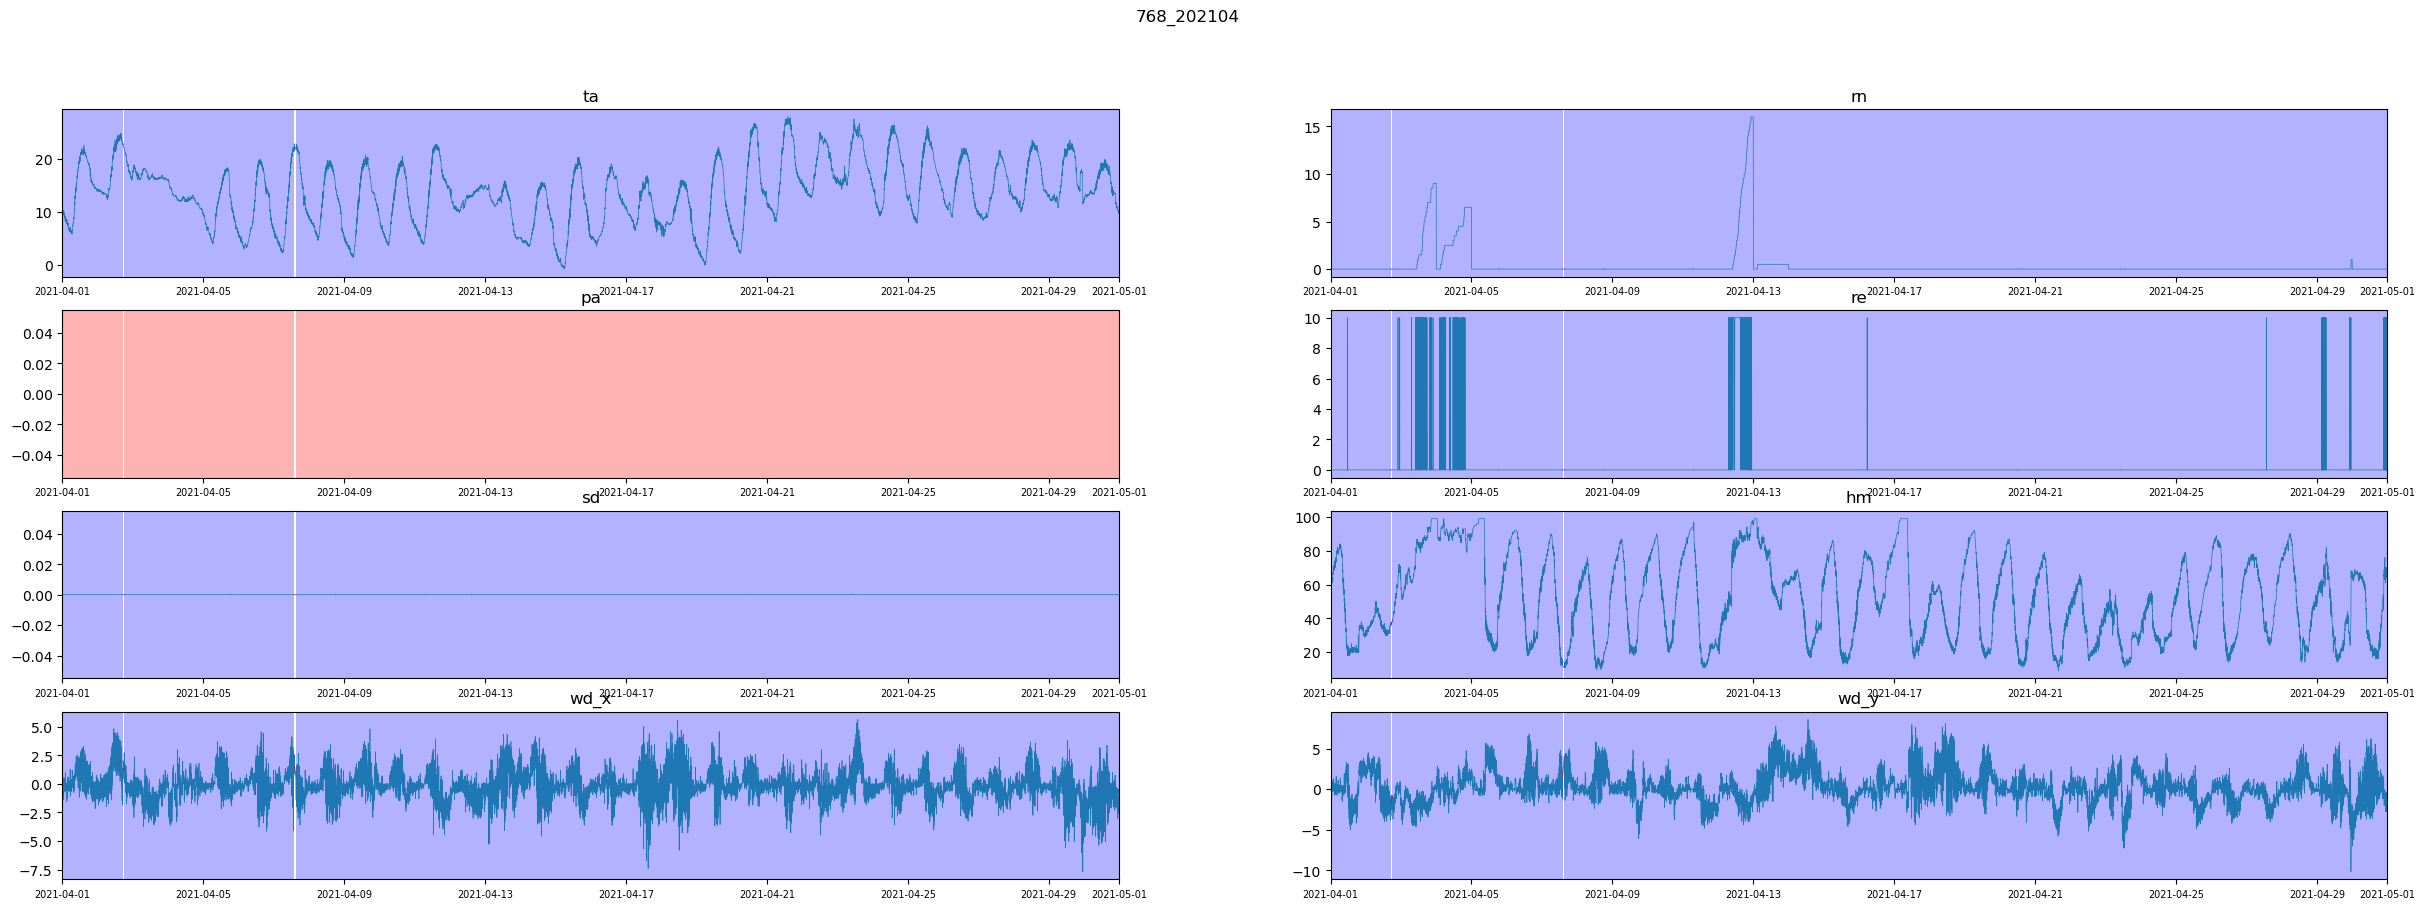

In [31]:
# pick_year = np.random.choice(years)
pick_year = 2021
pick_stn_id = np.random.choice(list(getattr(dlqc, f'min_{pick_year}')))
pick_month = np.random.choice(np.where(getattr(dlqc, f'min_{pick_year}')[pick_stn_id])[0]) + 1
# pick_year = 2021
# pick_stn_id = 562
# pick_month = 12


pick_min_df, pick_qcd_df = dfs_2021.get_min_qcd_df(pick_year, pick_month, pick_stn_id)
pick_min_df, pick_qcd_df, pick_intp_df = draw_graph(year=pick_year, month=pick_month, stn_id=pick_stn_id, min_df=pick_min_df, qcd_df=pick_qcd_df)
pick_min_df.describe()

In [32]:
pick_min_df.notnull().sum()

ta      43086
rn      43086
pa          0
re      43086
sd      43086
hm      43086
wd_x    43086
wd_y    43086
dtype: int64